In [1]:
import timm
import torch
import torchmetrics
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import lightning as L
import random
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torch.nn as nn

from tqdm import tqdm
from pathlib import Path
from torchvision.transforms import v2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch.callbacks import ModelCheckpoint
from copy import deepcopy
from timm.loss import SoftTargetCrossEntropy

from PIL import Image
from torchvision.datasets import CIFAR100
import torchvision
from torchmetrics import MetricCollection
from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassAUROC,
)
import glob

from IPython import get_ipython


def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)


set_seed()
L.seed_everything(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()
Seed set to 42


In [2]:
%load_ext tensorboard

In [3]:
classes_description = pd.read_csv('classes.csv')
classes_description

,pizza_type,class_id
0,альфредо,0
1,баварская,1
2,вегетарианская,2
3,ветчинаибекон,3
4,ветчинаигрибы,4
5,гавайская,5
6,грушаbbq,6
7,капричиоза,7
8,клубникаизефир,8
9,крем-чизсгрибами,9


In [4]:
train_classes = pd.read_csv('train.csv')
train_classes

,id,image_name,label
0,0,train_0000.jpg,0
1,1,train_0001.jpg,0
2,2,train_0002.jpg,0
3,3,train_0003.jpg,0
4,4,train_0004.jpg,0
...,...,...,...
6419,6419,train_6419.jpg,45
6420,6420,train_6420.jpg,45
6421,6421,train_6421.jpg,45
6422,6422,train_6422.jpg,45


In [5]:
print(len(train_classes['label'].unique()))

46


In [12]:
def calculate_normalization(train_dir = 'train/train_256/'):
    means = []
    stds = []
    image_sizes = []
    images_path = glob.glob(train_dir+'*')
    for i in range(len(images_path)):
        image = np.array(Image.open(images_path[i]))/255
        means.append(image.mean(axis = (0,1)))
        stds.append(image.std(axis = (0,1)))
        image_sizes.append(image.shape)

    means = np.array(means)
    stds = np.array(stds)
    print(np.array(image_sizes).mean(axis=0))
    return means.mean(axis=0),stds.mean(axis=0)

calculate_normalization()
        


[256. 256.   3.]


(array([0.66223061, 0.53081928, 0.40509563]),
 array([0.21449153, 0.22278006, 0.208873  ]))

In [75]:
sample_submission = pd.read_csv('submission.csv')
print(sample_submission)

        id  label
0        1      0
1        2      0
2        3      0
3        4      0
4        5      0
...    ...    ...
2131  2132      0
2132  2133      0
2133  2134      0
2134  2135      0
2135  2136      0

[2136 rows x 2 columns]


In [6]:
class pizza_dataset(Dataset):
    def __init__(self,transform=None,mode='train'):
        self.mode = mode
        self.data_dir = None
        if self.mode == 'train':
            self.data_dir = 'train/train_256/'
        if self.mode =='test':
            self.data_dir = 'test/test_256/'
        self.transform = transform
        self.images = glob.glob(self.data_dir+'*')
        if self.mode == 'train':
            self.class_labels  = pd.read_csv('train.csv')
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self,ind):
        if self.mode =='train':
            image = np.array(Image.open(self.images[ind]))
            if self.transform is not None:
                image = self.transform(image=image)
                image = image['image']
            cls = self.class_labels['label'][ind]
            return image,torch.tensor(cls,dtype = torch.long)
        if self.mode == 'test':
            image = np.array(Image.open(self.images[ind]))
            if self.transform is not None:
                image = self.transform(image=image)
                image = image['image']
            return image
        
train_transform = A.Compose([
    A.RandomBrightnessContrast(p=0.2,brightness_limit=0.2,contrast_limit=0.2),
    A.HueSaturationValue(hue_shift_limit=10,sat_shift_limit=15,val_shift_limit=10,p=0.2),
    A.Normalize(mean=[0.66223061, 0.53081928, 0.40509563], std=[0.21449153, 0.22278006, 0.208873  ]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Normalize(mean=[0.66223061, 0.53081928, 0.40509563], std=[0.21449153, 0.22278006, 0.208873  ]),
    ToTensorV2(),
    
])



full_train_dataset = pizza_dataset(transform=train_transform,mode='train')

train_dataset = deepcopy(full_train_dataset)
val_dataset   = deepcopy(full_train_dataset)

train_dataset.transform = train_transform
val_dataset.transform = test_transform

data_size = len(full_train_dataset)
data_split = 0.8

generator = torch.Generator().manual_seed(42)
train_idx, val_idx = torch.utils.data.random_split(
    range(len(full_train_dataset)), [int(data_size*data_split),len(full_train_dataset)-int(data_size*data_split)], generator=generator
)

train_dataset = torch.utils.data.Subset(train_dataset, train_idx.indices)
val_dataset   = torch.utils.data.Subset(val_dataset, val_idx.indices)

test_dataset = pizza_dataset(transform=test_transform,mode = 'test')


            


        

C:\Users\Andruxa\AppData\Local\Temp\ipykernel_20012\333639727.py:11: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  img = np.array(img_pil).transpose(1,2,0)


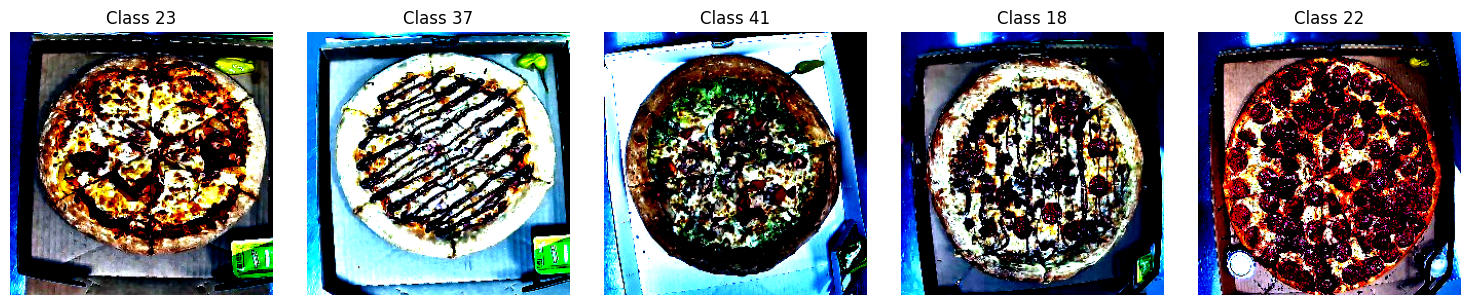

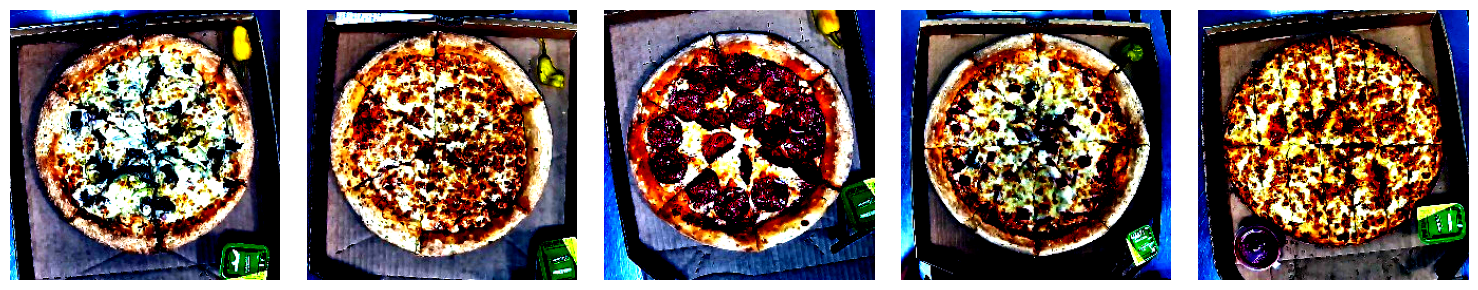

In [17]:
def show_augmented_batch(dataset, n=5,mode = 'train'):
    mean=np.array([0.66223061, 0.53081928, 0.40509563])
    std=np.array([0.21449153, 0.22278006, 0.208873  ])
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        if mode == 'train':
            img_pil, label = dataset[i]
            axs[i].set_title(f"Class {label}")
        else:
            img_pil = dataset[i]
        img = np.array(img_pil).transpose(1,2,0)
        img = np.clip(img, 0, 1)
        axs[i].imshow(img)
        axs[i].axis('off')
    plt.tight_layout()
    fig.savefig('show_augmentations.png',dpi=600)
    plt.show()

show_augmented_batch(train_dataset,  n=5)
show_augmented_batch(test_dataset,  n=5,mode = 'test')

In [8]:
train_loader = DataLoader(train_dataset.dataset, batch_size=256,shuffle=True)
val_loader = DataLoader(val_dataset.dataset, batch_size=256, shuffle=False)
test_loader =  DataLoader(test_dataset, batch_size=256,shuffle=False)

In [ ]:
from ranger21 import Ranger21  
from functools import partial

def my_optimizer_ranger(params, num_epochs=1, num_batches_per_epoch=len(train_loader), lr=1e-3):
    return Ranger21(params, lr=lr, num_epochs=num_epochs, num_batches_per_epoch=num_batches_per_epoch)

class LModel(L.LightningModule):
    def __init__(self, model, lr=0.001,optimizer_cls=torch.optim.AdamW,max_epochs = 30):
        super().__init__()
        self.save_hyperparameters(logger=False, ignore=["model"])
        self.lr = lr
        self.model = model
        self.criterion = nn.CrossEntropyLoss()
        metrics = MetricCollection([
            MulticlassAccuracy(num_classes=46,),
            MulticlassF1Score(num_classes=46,),
        
        ])
        self.train_metrics = metrics.clone(postfix="/train")
        self.val_metrics = metrics.clone(postfix="/val")
        self.test_metrics = metrics.clone(postfix="/test")
        self.optimizer_cls = optimizer_cls
        self.max_epochs = max_epochs
    
    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = self.optimizer_cls(
            self.model.parameters(),
            lr=self.lr,
            )
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer,
        )
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch", 
                "monitor": "loss"
            },
        }

    def training_step(self, batch, batch_idx):
        x,y = batch
        out = self.model(x)
        loss = self.criterion(out, y)
        self.train_metrics.update(out, y)
        self.log("loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.val_metrics.update(out, y)

    def on_train_epoch_end(self):
        self.log_dict(self.train_metrics.compute())
        self.train_metrics.reset()

        val_metrics = self.val_metrics.compute()
        self.log_dict(val_metrics)
        self.val_metrics.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        out = self.model(x)
        self.test_metrics.update(out, y)

    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()


def train_model(model,log_save_dir,exp_name,max_epochs = 10,monitor="MulticlassAccuracy/val",
                return_lightning_model = True,opt_cls = torch.optim.AdamW,lr=1e-3,opt_type = 'AdamW'):
    checkpoint_callback = ModelCheckpoint(
        monitor=monitor, mode="max", filename="model"
    )
    if opt_type !='ranger21':
        pl_model = LModel(model,optimizer_cls = opt_cls,lr = lr,max_epochs=max_epochs)
    else:
        pl_model = LModel(model,
        optimizer_cls= partial(my_optimizer_ranger,
                          num_epochs=max_epochs,
                          num_batches_per_epoch=len(train_loader),
                          lr=lr),
        lr=lr)
        
    trainer = L.Trainer(
        max_epochs=max_epochs,
        callbacks=[checkpoint_callback],
        num_sanity_val_steps=0,
        log_every_n_steps=10,
        logger=L.pytorch.loggers.TensorBoardLogger(save_dir=log_save_dir,name=exp_name),
        enable_progress_bar=True,
        precision="16-mixed"
    )
    trainer.fit(model = pl_model,train_dataloaders=train_loader,val_dataloaders=val_loader)
    if return_lightning_model:
        return pl_model
    else:
        return pl_model.model
def plot_losses_accs(base_model_name,port):
    log_dir = f'./saved_models/{base_model_name}'
    port = f'{port:.0f}'
    get_ipython().run_line_magic('tensorboard', f'--logdir {log_dir} --port {port}')

def test_model(model,model_dir,lightning_model=False):
    version_model = glob.glob(model_dir+'/*/*/model.ckpt')[-1]
    pl_model = LModel.load_from_checkpoint(version_model,model=model)
    if not lightning_model:
        pl_model = LModel(model)
    trainer = L.Trainer(
        enable_progress_bar=True,
        precision="16-mixed"
    )   
    predictions = trainer.predict(pl_model,dataloaders=test_loader)

    all_preds = []
    for batch_logits in predictions:
        preds = torch.argmax(batch_logits, dim=1)
        all_preds.extend(preds.cpu().tolist())

    return all_preds  

def create_submission_file(predictions,submission_name = 'Sharonova_Aleksandra.csv'):
    df = pd.DataFrame({
        'id': range(1, len(predictions) + 1),
        'label': predictions
    })

    df.to_csv(submission_name, index=False)


In [58]:
efficientnet_model = torchvision.models.efficientnet_b1(pretrained = True)

efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 46)



In [59]:
train_model(efficientnet_model,'./saved_models/efficientnet',exp_name = '',max_epochs=30,lr = 1e-4)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 6.6 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.288    Total estimated model params size (MB)
483       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


LModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [22]:
plot_losses_accs('efficientnet',port =2003)

Reusing TensorBoard on port 2003 (pid 8868), started 0:00:48 ago. (Use '!kill 8868' to kill it.)

In [73]:
predictions = test_model(efficientnet_model,'./saved_models/efficientnet')
print(predictions)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

[9, 34, 22, 7, 20, 4, 3, 42, 22, 22, 14, 37, 7, 22, 14, 20, 40, 45, 16, 7, 22, 16, 40, 33, 33, 45, 22, 20, 33, 7, 22, 37, 22, 27, 10, 14, 33, 7, 4, 22, 17, 34, 14, 22, 4, 33, 21, 33, 45, 22, 37, 4, 2, 16, 16, 34, 40, 23, 45, 33, 0, 22, 20, 37, 5, 4, 30, 34, 41, 9, 12, 14, 40, 40, 4, 33, 34, 4, 18, 22, 13, 15, 20, 44, 26, 37, 17, 22, 39, 18, 23, 5, 35, 19, 38, 37, 40, 1, 33, 44, 28, 23, 37, 33, 7, 39, 10, 38, 4, 15, 37, 34, 1, 32, 44, 38, 20, 22, 4, 1, 22, 37, 37, 4, 34, 45, 14, 4, 33, 11, 20, 20, 14, 24, 4, 11, 29, 12, 22, 40, 18, 33, 37, 11, 22, 4, 45, 5, 1, 23, 17, 22, 17, 4, 4, 17, 23, 17, 15, 33, 4, 33, 20, 37, 4, 18, 38, 41, 14, 4, 15, 18, 22, 7, 20, 20, 37, 5, 22, 1, 17, 20, 10, 29, 37, 15, 1, 7, 22, 17, 23, 37, 3, 4, 4, 11, 7, 4, 35, 4, 23, 32, 5, 23, 15, 11, 17, 2, 45, 38, 33, 12, 35, 45, 1, 22, 1, 33, 14, 37, 15, 9, 44, 20, 21, 1, 14, 24, 33, 17, 37, 27, 33, 22, 37, 14, 22, 38, 23, 22, 4, 15, 33, 23, 22, 4, 33, 22, 37, 12, 14, 42, 4, 4, 42, 7, 4, 22, 5, 5, 33, 5, 33, 4, 41, 22

In [77]:
create_submission_file(predictions)

In [83]:
class ModifiedMobileNet(nn.Module):
    def __init__(self, num_classes=46, dropout=0.3, model_type='small'):
        super().__init__()
        if model_type == 'small':
            mobilenet = torchvision.models.mobilenet_v3_small(pretrained=True)
        elif model_type == 'large':
            mobilenet = torchvision.models.mobilenet_v3_large(pretrained=True)
        else:
            raise ValueError(f"Unsupported model_type: {model_type}")

        self.features = mobilenet.features
        self.pool = nn.AdaptiveAvgPool2d(1)

        last_channel = mobilenet.classifier[0].in_features

        self.bn = nn.BatchNorm2d(last_channel)
        self.relu = nn.ReLU(inplace=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(last_channel, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)                 
        x = self.bn(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = x.view(x.size(0), -1)      
        x = self.fc(x)
        return x


mobilenet_model = ModifiedMobileNet(model_type='large')

In [84]:
train_model(mobilenet_model,'./saved_models/mobilenetv3_large',exp_name = '',max_epochs=30,lr = 1e-4)

Using 16bit Automatic Mixed Precision (AMP)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params | Mode 
------------------------------------------------------------
0 | model         | ModifiedMobileNet | 3.0 M  | train
1 | criterion     | CrossEntropyLoss  | 0      | train
2 | train_metrics | MetricCollection  | 0      | train
3 | val_metrics   | MetricCollection  | 0      | train
4 | test_metrics  | MetricCollection  | 0      | train
------------------------------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.072    Total estimated model params size (MB)
264       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


LModel(
  (model): ModifiedMobileNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): Hardswish()
      )
      (1): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (1): Conv2dNormActivation(
            (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          )
        )
      )
      (2): InvertedResidual(
        (block): Sequential(
          (0): Conv2dNormActivation

In [24]:
plot_losses_accs('mobilenetv3_large',port=2002)

Reusing TensorBoard on port 2002 (pid 13656), started 0:01:13 ago. (Use '!kill 13656' to kill it.)

In [86]:
predictions_mobilenet_large = test_model(mobilenet_model,'./saved_models/mobilenetv3_large')
create_submission_file(predictions_mobilenet_large)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [6]:
densenet_model = torchvision.models.densenet121(pretrained = True)

densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, 46)

c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train_model(densenet_model,'./saved_models/densenet121',exp_name = '',max_epochs=30,lr = 1e-4)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | DenseNet         | 7.0 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-------------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [9]:
predictions_densenet = test_model(densenet_model,'./saved_models/densenet121')
create_submission_file(predictions_densenet)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [27]:
plot_losses_accs('densenet121',port=2004)

Reusing TensorBoard on port 2004 (pid 20940), started 0:00:44 ago. (Use '!kill 20940' to kill it.)

In [10]:
efficientnet_model = torchvision.models.efficientnet_b1(pretrained = True)

efficientnet_model.classifier[1] = nn.Linear(efficientnet_model.classifier[1].in_features, 46)

c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B1_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
train_model(efficientnet_model,'./saved_models/efficientnet_with_ranger21',exp_name = '',max_epochs=30,lr = 1e-4,opt_cls = my_optimizer_ranger,opt_type='ranger21')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 6.6 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-------------------------------------------------

Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.0001

Important - num_epochs of training = ** 30 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 171 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 561 of 780
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 301


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.0001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 561....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

error in warmdown - lr below min lr. current lr = 2.9999999999999997e-05
auto handling but please report issue!


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


LModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [12]:
train_model(efficientnet_model,'./saved_models/efficientnet_with_ranger21',exp_name = '',max_epochs=10,lr = 1e-3,opt_cls = my_optimizer_ranger,opt_type='ranger21')

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | EfficientNet     | 6.6 M  | train
1 | criterion     | CrossEntropyLoss | 0      | train
2 | train_metrics | MetricCollection | 0      | train
3 | val_metrics   | MetricCollection | 0      | train
4 | test_metrics  | MetricCollection | 0      | train
-----------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.288    Total estimated model params size (MB)
483       Modules in train mode
0         Modules in eval mode


Ranger21 optimizer ready with following settings:

Core optimizer = AdamW
Learning rate of 0.001

Important - num_epochs of training = ** 10 epochs **
please confirm this is correct or warmup and warmdown will be off

Warm-up: linear warmup, over 57 iterations

Lookahead active, merging every 5 steps, with blend factor of 0.5
Norm Loss active, factor = 0.0001
Stable weight decay of 0.0001
Gradient Centralization = On

Adaptive Gradient Clipping = True
	clipping value of 0.01
	steps for clipping = 0.001

Warm-down: Linear warmdown, starting at 72.0%, iteration 187 of 260
warm down will decay until 3e-05 lr


Training: |          | 0/? [00:00<?, ?it/s]

params size saved
total param groups = 1
total params in groups = 301


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update = Warmup complete - lr set to 0.001



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


** Ranger21 update: Warmdown starting now.  Current iteration = 187....



Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


LModel(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activati

In [14]:
plot_losses_accs('efficientnet_with_ranger21',port=1007)

Reusing TensorBoard on port 1007 (pid 14420), started 0:02:00 ago. (Use '!kill 14420' to kill it.)

In [15]:
efficientnet_model_ranger21_preds = test_model(efficientnet_model,'./saved_models/efficientnet_with_ranger21')
create_submission_file(efficientnet_model_ranger21_preds)

Using 16bit Automatic Mixed Precision (AMP)
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\Andruxa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

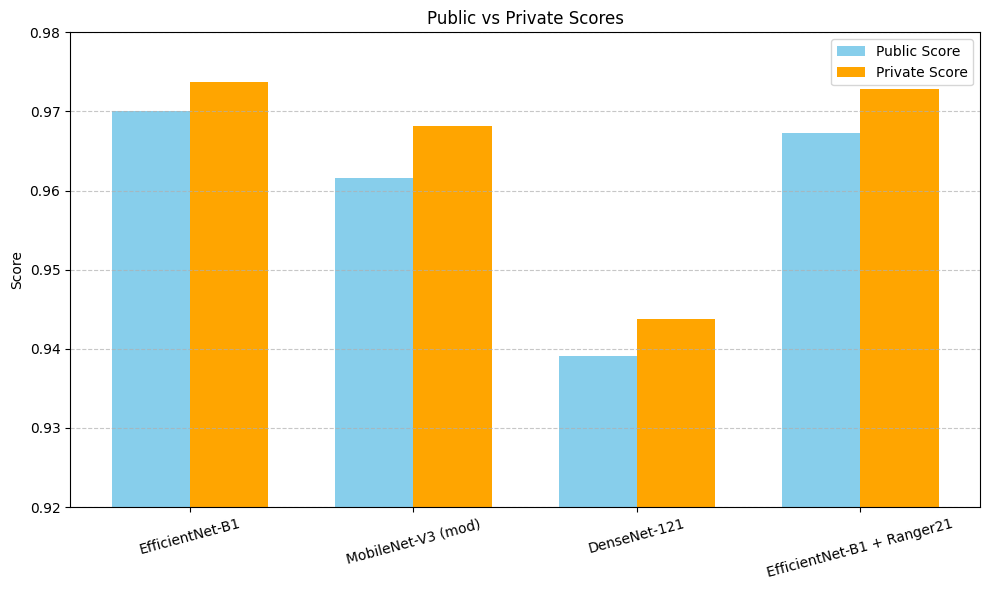

In [31]:
import matplotlib.pyplot as plt

models = [
    "EfficientNet-B1",
    "MobileNet-V3 (mod)",
    "DenseNet-121",
    "EfficientNet-B1 + Ranger21"
]

public_scores = [0.97003, 0.96161, 0.93913, 0.96722]
private_scores = [0.97378, 0.96816, 0.94382, 0.97284]

x = range(len(models))
plt.figure(figsize=(10, 6))
bar_width = 0.35
plt.xlabel("")
plt.ylabel("Score")
plt.title("Public vs Private Scores")
plt.xticks(x, models, rotation=15)
plt.ylim(0.92, 0.98)
plt.bar([i - bar_width/2 for i in x], public_scores, width=bar_width, label="Public Score", color='skyblue')
plt.bar([i + bar_width/2 for i in x], private_scores, width=bar_width, label="Private Score", color='orange')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('result_scores.png',dpi=600)
plt.show()